# Student Performance Dataset

## Using Survey Data to Identify Failing Students

### Problem

Failing students add numerous tangible and intangible costs to schools, school districts, and even entire education systems. For example, failing students are usually required to retake classes, adding hours to teacher and paraeducator workloads; costly interventions are applied to failing students; and - fairly or unfairly - media and public attention is often drawn to the number of failing students in school, district, or state jurisdictions.

Anecdotally, teachers and other education professionals observe common characteristics among their failing students. What if student student behavior surveys could be use to pick out common traits amongst failing students? This analysis attempts to answer this question by applying machine learning techniques from scikit-learn to a dataset containing student grades and behavioral surveys, found at: [UCI Machine Learning Repository - Student Performance Data Set](http://archive.ics.uci.edu/ml/datasets/Student+Performance).

### Import modules

First, do the initial import of necessary packages. SciKit Learn modules will be introduced as applicable.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Check Data

Next, look at the data to see if it is in the correct shape and has been processed correctly.

In [2]:
df = pd.read_csv('../data/processed/cmbd.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 52 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Unnamed: 0         1044 non-null   int64
 1   age                1044 non-null   int64
 2   Medu               1044 non-null   int64
 3   Fedu               1044 non-null   int64
 4   traveltime         1044 non-null   int64
 5   studytime          1044 non-null   int64
 6   failures           1044 non-null   int64
 7   schoolsup          1044 non-null   int64
 8   famsup             1044 non-null   int64
 9   paid               1044 non-null   int64
 10  activities         1044 non-null   int64
 11  nursery            1044 non-null   int64
 12  higher             1044 non-null   int64
 13  internet           1044 non-null   int64
 14  romantic           1044 non-null   int64
 15  famrel             1044 non-null   int64
 16  freetime           1044 non-null   int64
 17  goout         

,Unnamed: 0,age,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,...,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
0,0,18,4,4,2,2,0,1,0,0,...,0,0,1,1,0,0,0,0,1,0
1,1,17,1,1,1,2,0,0,1,0,...,1,0,0,1,0,0,0,1,0,0
2,2,15,1,1,1,2,3,1,0,1,...,1,0,0,0,0,1,0,0,1,0
3,3,15,4,2,1,3,0,0,1,1,...,0,1,0,0,1,0,0,0,1,0
4,4,16,3,3,1,2,0,0,1,1,...,1,0,0,0,1,0,0,1,0,0


So far, everything seems pretty good. Let's take a look at the final grade, `G3`, that we are interested in examining to find failing students.

In [3]:
df['G3'].describe()

count    1044.000000
mean       11.341954
std         3.864796
min         0.000000
25%        10.000000
50%        11.000000
75%        14.000000
max        20.000000
Name: G3, dtype: float64

Some additional processing is required. We are looking to pick out faling students - essentially a binary classification problem - so we should set up a binary variable to track wheter or not students are failing. Accoriding to [Wikipedia](https://en.wikipedia.org/wiki/Academic_grading_in_Portugal), anything less than a final grade of 9.5 is considered 'not sufficient'. 

### Finalize Pre-processing and Scaling

Recode the binary variable and check the value counts.

In [4]:
df['not_sufficient'] = np.where(df['G3'] >= 9.5, 0.0, 1.0)
df['not_sufficient'].value_counts()

0.0    814
1.0    230
Name: not_sufficient, dtype: int64

Set up the X and y variable (`'not_sufficient'`) for machine learning.

In [5]:
y = df['not_sufficient']
X = df.drop(['G1','G2','G3','not_sufficient'], axis=1)

Import the necessary models for test-train split and scaling; implement these modules.

In [6]:
#Import ML models:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import confusion_matrix

# Splitting the dataset into training and test set:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature Scaling:

scaler_x = MinMaxScaler((-1,1))
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

### Dummy Classifier

First, establish a baseline using a dummy classifier. This dummy classier simply picks out the most frequent class in the dataset, the students whose grades are sufficient.

Accuracy: 0.748


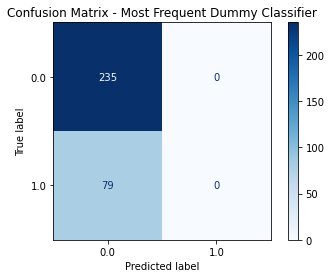

In [7]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix

# Define dummy classifier
dummy = DummyClassifier(strategy='most_frequent')
# Fit model
dummy.fit(X_train, y_train)
# Make predictions
yhat_dummy = dummy.predict(X_test)
# calculate accuracy
accuracy_dummy = accuracy_score(y_test, yhat_dummy)
print('Accuracy: %.3f' % accuracy_dummy)
#3 Plot confusion matrix
_= plot_confusion_matrix(dummy, X_test, y_test, cmap="Blues")
_ = plt.title("Confusion Matrix - Most Frequent Dummy Classifier")

### Logistic Regression

Now that we have established a baseline, start with a simple model, logistic regression, to pick out which students have grades of 'not sufficient'. For all of the models, we will use `GridSearchCV` for hyperparmeter tuning.

Best parameters: {'C': 1, 'penalty': 'l1'}
Accuracy: 0.768
Recall: 0.228


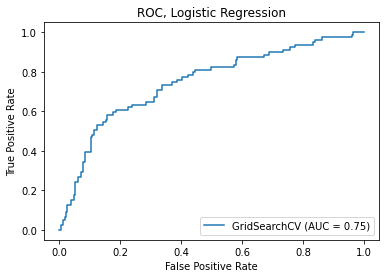

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (plot_precision_recall_curve, plot_roc_curve, 
                             f1_score, plot_roc_curve, recall_score, 
                             plot_confusion_matrix)

# Set up parameters to be searched over
lr_params = {
    'C': (0.001,0.01,0.1,1,10,100),
    'penalty': ('l1', 'l2'),
}

# Fit the model and predict
gslr = GridSearchCV(LogisticRegression(random_state=42, solver='liblinear'), lr_params)
gslr.fit(X_train, y_train)

y_pred = gslr.predict(X_test)

# Score the grid search model with the testing data
lr_acc = gslr.score(X_test, y_test)
lr_recall = recall_score(y_test, y_pred)


# Print best parameters, accuracy, and recall
print('Best parameters: %r' % gslr.best_params_ )
print('Accuracy: %.3f' % lr_acc)
print('Recall: %.3f' % lr_recall)

# Plot
_ = plot_roc_curve(gslr,X_test,y_test)
_ = plt.title("ROC, Logistic Regression");

The predictions using logistic regression are fairly accurate. However, let's take a closer look at recall. Recall is an important metric for this problem. We don't want to identify just some failing students; we want to correctly identify as many of the failing students as possible. The recall score is quite low. Let's take a closer look at the confusion matrix to see what is going on:

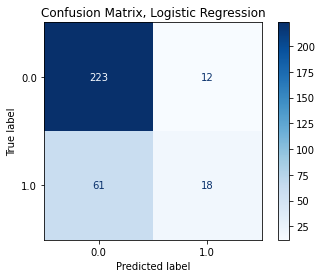

In [9]:
_ = plot_confusion_matrix(gslr, X_test, y_test, cmap="Blues")
_ = plt.title("Confusion Matrix, Logistic Regression")
plt.show()

Only 7 out of the 26 failing students in the test set were correctly identified. Let's take a look at some other models to explore the problem.

### KNN Classifier

We will use the same method as above for hyperparameter tuning, `GridsearchCV`, this time train the data on a KNN classifier.

Best parameters: {'metric': 'euclidean', 'n_neighbors': 13, 'weights': 'uniform'}
Accuracy: 0.748
Recall: 0.038


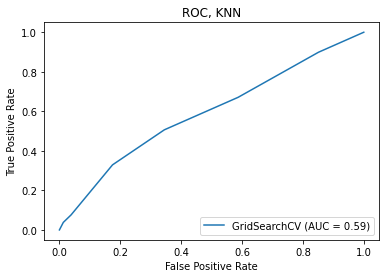

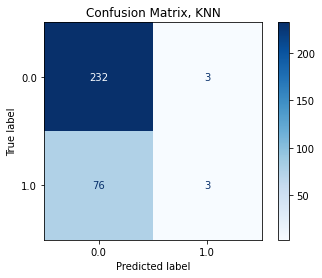

In [10]:
from sklearn.neighbors import KNeighborsClassifier

knn_params = {
    'n_neighbors': [3,5,11,13,19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean','manhattan']
}

gsknn = GridSearchCV(KNeighborsClassifier(),knn_params)
gsknn.fit(X_train,y_train)

y_predict_knn=gsknn.predict(X_test)

accuracy_knn=gsknn.score(X_test,y_test)
recall = recall_score(y_test, y_predict_knn)
knn_f1 = f1_score(y_test, y_predict_knn)

print('Best parameters: %r' %gsknn.best_params_)
print('Accuracy: %.3f' % accuracy_knn)
print('Recall: %.3f' % recall)

plot_roc_curve(gsknn,X_test,y_test)
plt.title("ROC, KNN")

plot_confusion_matrix(gsknn, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix, KNN");

The KNN approach does better than the dummy classifier, but not as well as logistic regression. Also, the recall score is worse. This approach only detected one failing student.

Let's try another common approach, the random forest.


### Random Forest

Best parameters: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 120}
Accuracy: 0.768
Recall: 0.165


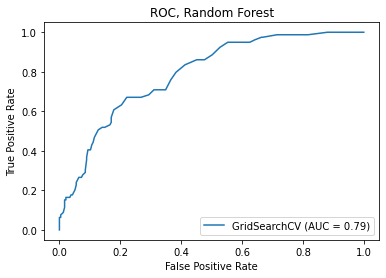

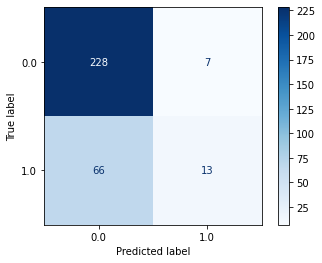

In [11]:
from sklearn.ensemble import RandomForestClassifier

#Apply RF to the training data:

rf_params = {
    'n_estimators' : [100, 120, 140],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample']
}

gsrf = GridSearchCV(RandomForestClassifier(),rf_params)

gsrf.fit(X_train,y_train)

# Predict using model:

y_predict_gsrf=gsrf.predict(X_test)



accuracy_rf=gsrf.score(X_test,y_test)
recall = recall_score(y_test, y_predict_gsrf)

print('Best parameters: %r' %gsrf.best_params_)
print('Accuracy: %.3f' % accuracy_rf)
print('Recall: %.3f' % recall)

plot_roc_curve(gsrf,X_test,y_test)
plt.title("ROC, Random Forest")

plot_confusion_matrix(gsrf, X_test, y_test, cmap="Blues");

These results are basically the same as the KNN results. A story is emerging, but let's try one more model.

### Gradient Boosting

Best parameters: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 50}
Accuracy: 0.771
Recall: 0.228


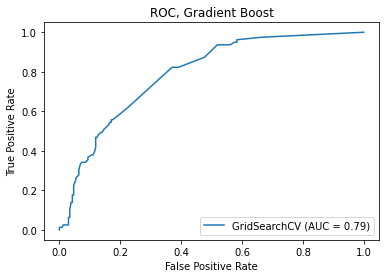

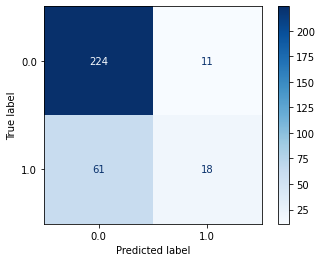

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

gb_params = {
    'n_estimators':[5,50,250,500],
    'max_depth':[1,3,5,7,9],
    'learning_rate':[0.01,0.1,1,10,100]
}

gsgb = GridSearchCV(GradientBoostingClassifier(), gb_params)
gsgb.fit(X_train, y_train)

y_predict_gsgb = gsgb.predict(X_test)

print('Best parameters: %r' %gsgb.best_params_)
accuracy_gsgb=gsgb.score(X_test,y_test)
print('Accuracy: %.3f' % accuracy_gsgb)
recall = recall_score(y_test, y_predict_gsgb)
print('Recall: %.3f' % recall)

_ = plot_roc_curve(gsgb,X_test,y_test)
_ = plt.title("ROC, Gradient Boost")
plt.show()

_ = plot_confusion_matrix(gsgb, X_test, y_test, cmap="Blues")

This approach does better, though still not very good, in terms of recall. Accuracy is about the same as the dummy classifier, and this observation points to our problem.

### Conclusion and Next Steps

The conclusion that I come to is that there is simply not enough data to deal this problem. The accuracy of each model at first looks decent, but looking at this score alone masks the fact that each model is really only picking out the most common class, like the dummy classifier.

The most obvious recommendation is to gather more data and repeat the same processes with a larrger dataset. This dataset is slightly imbalanced, so similiar techniqes might be used along with oversampling techniqes — keeping in mind that the dataset as it has been processed is made up of non-continuous variables. In taking this approach, gradient boost looks like a promising model, as it shows the most improvements in recall which — it has been noted — is an important metric for identifying failing students in this context.